In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Corrected import for Sequential
from tensorflow.keras import layers, models # Import models here
from tensorflow.keras.models import Sequential # Import Sequential from models
from tensorflow.keras import callbacks# Import callbacks directly
import math
from datetime import timedelta, datetime

In [167]:
FEATURES_TO_USE = [
    # Core price/volume (5)
    'Close', 'High', 'Low', 'Volume', 'price_change_pct',

    # Technical indicators (6)
    'MA_20', 'MA_50', 'MA_200', 'RSI', 'volatility_20d', 'momentum_10d',

    # Key fundamentals (4)
    'eps', 'revenue', 'netIncomeRatio', 'PE_ratio',

    # Context (2)
    'days_since_financial_update', 'market_cap'
]

In [168]:
# --- Transformer Components (Adapted from TF_Binning, simplified for time series) ---

def positional_encoding(length, depth):
    """Calculates positional encoding for a sequence."""
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(layers.Layer):
    """Combines input features with positional encoding."""
    def __init__(self, d_model, max_len=2048): # Adjusted max_len for potentially longer sequences
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.pos_encoding = positional_encoding(self.max_len, d_model)

        # Add a Dense layer to project input features to d_model dimension
        self.projection_layer = layers.Dense(d_model)


    def call(self, x):
        # x is assumed to be the input sequence of numerical features
        # x shape: (batch_size, input_seq_length, num_features)

        # Project input features to d_model dimension
        x = self.projection_layer(x) # Output shape: (batch_size, input_seq_length, d_model)

        # Add positional encoding
        seq_len = tf.shape(x)[1]
        # Ensure positional encoding slice matches sequence length and d_model
        x += self.pos_encoding[tf.newaxis, :seq_len, :]
        return x

class BaseAttention(layers.Layer):
    """Base class for attention layers."""
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = layers.MultiHeadAttention(**kwargs)
        self.layernorm = layers.LayerNormalization()
        self.add = layers.Add()

class GlobalSelfAttention(BaseAttention):
    """Global self-attention layer."""
    def call(self, x):
        # Keras MultiHeadAttention automatically handles masks if attached to the input
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class TransformerEncoderLayer(layers.Layer):
    """A single Transformer encoder layer."""
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        # Using Sequential from tensorflow.keras.models
        self.ffn = Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model),
            layers.Dropout(dropout_rate)
        ])
        self.add = layers.Add()
        self.layer_norm = layers.LayerNormalization()

    def call(self, x):
        # Self-attention
        x = self.self_attention(x)
        # Feed-forward network
        x = self.add([x, self.ffn(x)])
        x = self.layer_norm(x)
        return x

class TransformerModel(models.Model):
    """The complete Transformer model for time series prediction."""
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_length, num_features, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_seq_length = input_seq_length
        self.num_features = num_features

        # Positional Embedding layer (handles numerical input + positional encoding)
        # vocab_size and use_embedding are not needed for numerical input
        # The PositionalEmbedding layer now handles the initial projection to d_model
        self.pos_embedding = PositionalEmbedding(d_model=d_model, max_len=input_seq_length)

        # Transformer Encoder layers
        self.encoder_layers = [
            TransformerEncoderLayer(d_model, num_heads, dff, dropout_rate)
            for _ in range(num_layers)
        ]

        # Final Dense layer to predict the single target value
        self.final_layer = layers.Dense(1)

    def call(self, inputs):
        # inputs shape: (batch_size, input_seq_length, num_features)

        # Apply positional embedding (includes projection to d_model)
        x = self.pos_embedding(inputs) # Output shape: (batch_size, input_seq_length, d_model)

        # Pass through encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x) # Output shape: (batch_size, input_seq_length, d_model)

        # We want to predict the next step's value based on the *last* output of the sequence
        # Take the output corresponding to the last time step in the input sequence
        last_step_output = x[:, -1, :] # Shape: (batch_size, d_model)

        # Pass the last step's output through the final dense layer to get the prediction
        predictions = self.final_layer(last_step_output) # Shape: (batch_size, 1)

        return predictions

In [169]:
# --- Data Preparation (Adapted from LSTM notebook) ---

def prepare_transformer_data(df, target_col='Close', sequence_length=60):
    """
    Prepare data for Transformer model by creating sequences.
    Based on prepare_lstm_data, but tailored for Transformer input/output.
    """
    print("\n==== Preparing Data for Transformer Model ====")

    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Please set the 'date' column as the index.")
        return None, None, None, None, None, None, None, None

    # Use the globally defined list of features
    # Ensure all selected features exist in the dataframe
    feature_columns = [col for col in FEATURES_TO_USE if col in df.columns]

    # Ensure the target column is always included in the features list
    if target_col not in feature_columns:
        if target_col in df.columns:
            feature_columns.append(target_col) # Add it if it exists in df but not in FEATURES_TO_USE
        else:
            print(f"Error: Target column '{target_col}' not found in the DataFrame.")
            return None, None, None, None, None, None, None, None

    # Check for any specified features that are missing from the DataFrame
    missing_features = [col for col in FEATURES_TO_USE if col not in df.columns]
    if missing_features:
        print(f"Warning: The following specified features are missing from the DataFrame: {missing_features}")
        # The feature_columns list already excludes these, so no further action needed here

    if not feature_columns:
        print("Error: No valid features selected or found in the DataFrame. Exiting data preparation.")
        return None, None, None, None, None, None, None, None

    print(f"Using {len(feature_columns)} features: {feature_columns[:10]}{'...' if len(feature_columns) > 10 else ''}")

    # Create a new dataframe with selected features, dropping NaN rows
    # Only drop NaNs based on the selected feature columns
    data = df[feature_columns].dropna()
    data_for_plotting_index = data.index # Store index of the data *after* dropping NaNs for accurate plotting

    # Check if enough data remains after dropping NaNs
    # Need at least one sequence + one target value
    if len(data) < sequence_length + 1:
        print(f"Error: Not enough data ({len(data)} rows) after dropping NaNs to create sequences of length {sequence_length}.")
        return None, None, None, None, None, None, None, None

    # Split into training and test sets (70% train, 30% test) based on the cleaned data length
    train_size_after_dropna = int(len(data) * 0.7)
    train_data = data.iloc[:train_size_after_dropna]
    test_data = data.iloc[train_size_after_dropna:]

    # Check if train/test sets are large enough to create at least one sequence
    if len(train_data) < sequence_length or len(test_data) < sequence_length: # Min 1 sequence needed from each
         print(f"Error: Not enough data in train ({len(train_data)}) or test ({len(test_data)}) set after splitting to create sequences of length {sequence_length}.")
         return None, None, None, None, None, None, None, None


    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")

    # Normalize the data - store scalers for later inverse transformation
    scalers = {}
    train_scaled = pd.DataFrame(index=train_data.index) # Preserve index
    test_scaled = pd.DataFrame(index=test_data.index) # Preserve index

    for column in feature_columns: # Iterate over the actual columns being used
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Fit scaler on training data
        train_scaled[column] = scaler.fit_transform(train_data[column].values.reshape(-1, 1)).flatten()
        # Transform test data with the same scaler
        test_scaled[column] = scaler.transform(test_data[column].values.reshape(-1, 1)).flatten()
        # Store scaler for inverse transformation later
        scalers[column] = scaler

    # Create sequences for Transformer
    def create_sequences(data_df, seq_length, target_col_name):
        X, y = [], []
        data_values = data_df.values # Use .values to work with numpy arrays
        try:
            # Find the index of the target column in the current data_values array
            target_idx_in_values = data_df.columns.get_loc(target_col_name)
        except KeyError:
            print(f"Error: Target column '{target_col_name}' not found in the DataFrame slice used for sequence creation.")
            return np.array([]), np.array([]) # Return empty arrays on error

        for i in range(len(data_values) - seq_length):
            # Input sequence X: sequence_length time steps of all features (from i up to i + seq_length - 1)
            seq_x = data_values[i:(i + seq_length)]
            # Target y: the target value at the end of the sequence + 1 (i.e., at index i + seq_length)
            seq_y = data_values[i + seq_length, target_idx_in_values] # Get target from the next time step
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    # Generate training sequences
    X_train, y_train = create_sequences(train_scaled, sequence_length, target_col)
    # Generate test sequences
    X_test, y_test = create_sequences(test_scaled, sequence_length, target_col)

    # Check if sequences were created successfully
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Error: Sequence creation failed. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        return None, None, None, None, None, None, None, None


    print(f"Training sequences shape: {X_train.shape}") # Should be (num_samples, sequence_length, num_features)
    print(f"Test sequences shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test, scalers, feature_columns, data_for_plotting_index, train_size_after_dropna

In [170]:
# --- Model Training (Adapted from LSTM notebook) ---

def train_transformer_model(X_train, y_train, X_test, y_test, sequence_length, num_features,
                            num_layers=2, d_model=64, num_heads=4, dff=128, dropout_rate=0.1,
                            epochs=50, batch_size=32):
    """
    Build and train the Transformer model.
    """
    print("\n==== Training Transformer Model ====")
    if X_train.shape[0] == 0:
        print("Error: X_train is empty. Cannot train model.")
        return None, None

    # Build the Transformer model
    model = TransformerModel(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_seq_length=sequence_length,
        num_features=num_features,
        dropout_rate=dropout_rate
    )

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Can tune learning_rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Build the model by passing a dummy input to create the layers
    # This is necessary to see the model summary before training
    dummy_input = tf.zeros((1, sequence_length, num_features))
    model(dummy_input)

    # Print model summary
    model.summary()

    # Callbacks for more robust training
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1)

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, reduce_lr], # Re-enabled callbacks
                        verbose=1)

    print("Model training complete.")
    return model, history

In [171]:
# --- Model Evaluation (Adapted from LSTM notebook) ---

def evaluate_model(model, X_train, y_train, X_test, y_test, scalers, target_col='Close'):
    """
    Evaluate the Transformer model performance.
    """
    print("\n==== Evaluating Model Performance ====")

    if model is None:
        print("Error: Model is not trained. Cannot evaluate.")
        return None, None, None

    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found.")
        return None, None, None
    scaler = scalers[target_col] # Get the specific scaler for the target column

    # Make predictions on training and test sets
    train_predictions_scaled = model.predict(X_train)
    test_predictions_scaled = model.predict(X_test)

    # Inverse transform predictions to original scale
    train_predictions = scaler.inverse_transform(train_predictions_scaled)
    test_predictions = scaler.inverse_transform(test_predictions_scaled)

    # Inverse transform actual values (y_train, y_test) to original scale for comparison
    # y_train and y_test are 1D, so reshape them to 2D for inverse_transform
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Ensure shapes match before calculating metrics (as in original code)
    if y_train_orig.shape[0] != train_predictions.shape[0]:
        print(f"Warning: Train actual ({y_train_orig.shape}) and prediction ({train_predictions.shape}) shapes mismatch. Truncating.")
        min_len_train = min(y_train_orig.shape[0], train_predictions.shape[0])
        y_train_orig = y_train_orig[:min_len_train]
        train_predictions = train_predictions[:min_len_train]

    if y_test_orig.shape[0] != test_predictions.shape[0]:
        print(f"Warning: Test actual ({y_test_orig.shape}) and prediction ({test_predictions.shape}) shapes mismatch. Truncating.")
        min_len_test = min(y_test_orig.shape[0], test_predictions.shape[0])
        y_test_orig = y_test_orig[:min_len_test]
        test_predictions = test_predictions[:min_len_test]

    # Calculate metrics
    metrics = {
        'train_rmse': math.sqrt(mean_squared_error(y_train_orig, train_predictions)),
        'test_rmse': math.sqrt(mean_squared_error(y_test_orig, test_predictions)),
        'train_mae': mean_absolute_error(y_train_orig, train_predictions),
        'test_mae': mean_absolute_error(y_test_orig, test_predictions),
        'train_r2': r2_score(y_train_orig, train_predictions),
        'test_r2': r2_score(y_test_orig, test_predictions)
    }

    # Print metrics
    print(f"Training RMSE: {metrics['train_rmse']:.2f}, Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Training MAE: {metrics['train_mae']:.2f}, Test MAE: {metrics['test_mae']:.2f}")
    print(f"Training R²: {metrics['train_r2']:.4f}, Test R²: {metrics['test_r2']:.4f}")

    return train_predictions, test_predictions, metrics


In [172]:
# --- Future Prediction (Adapted from LSTM notebook) ---

def predict_future_transformer(model, df_original, scalers, feature_columns, target_col='Close', sequence_length=60, days_to_predict=365):
    """
    Predict future values using the trained Transformer model.
    df_original: The original dataframe (before any processing specific to train/test splits).
    scalers: Dictionary of scalers for each feature.
    feature_columns: List of feature column names used in the model.
    """
    print(f"\n==== Predicting {days_to_predict} Days into the Future for {GLOBAL_STOCK_TICKER} ====")
    if model is None:
        print("Error: Model is not trained. Cannot predict future.")
        return None, None

    # We need the last 'sequence_length' days of data to start the prediction process.
    # This data should be processed (NaNs dropped for the relevant features) and scaled.

    # 1. Get the relevant columns from the original dataframe and drop NaNs
    data_for_future_base = df_original[feature_columns].dropna()

    if len(data_for_future_base) < sequence_length:
        print(f"Error: Not enough historical data ({len(data_for_future_base)} rows after NaN drop) to form an initial sequence of length {sequence_length} for future prediction.")
        return None, None

    # 2. Get the last 'sequence_length' records from this cleaned data (unscaled)
    last_sequence_actual_df = data_for_future_base.tail(sequence_length).copy()

    # 3. Scale this initial sequence using the saved scalers
    current_sequence_scaled_list = []
    for col_name in feature_columns: # Iterate in the order of feature_columns
        if col_name in scalers:
            # Reshape because scaler expects 2D array
            scaled_col_data = scalers[col_name].transform(last_sequence_actual_df[col_name].values.reshape(-1, 1)).flatten()
            current_sequence_scaled_list.append(scaled_col_data)
        else:
            # This should ideally not happen if all features used for training have scalers
            print(f"Warning: Scaler for column '{col_name}' not found during future prediction preparation. Using unscaled values (this may lead to errors).")
            current_sequence_scaled_list.append(last_sequence_actual_df[col_name].values.flatten())

    # Transpose to get shape (sequence_length, num_features)
    current_sequence_scaled = np.array(current_sequence_scaled_list).T

    # Get target scaler for inverse transforming predictions
    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found for inverse transformation.")
        return None, None
    target_scaler = scalers[target_col]

    # Find the index of the target column in the feature_columns list
    try:
        target_idx_in_features = feature_columns.index(target_col)
    except ValueError:
        print(f"Error: Target column '{target_col}' not found in feature_columns list: {feature_columns}")
        return None, None

    future_predictions_unscaled = [] # Store unscaled (actual price) predictions

    # Maintain a rolling window of the last 'sequence_length' feature vectors (scaled)
    # This is what the Transformer will use as input for the next prediction.
    rolling_input_sequence_scaled = current_sequence_scaled.copy()

    # Generate future dates
    last_date_in_data = df_original.index[-1] # Use the last date from the original full dataset
    future_dates = [last_date_in_data + timedelta(days=i + 1) for i in range(days_to_predict)]

    # Iteratively predict future values
    for i in range(days_to_predict):
        # Reshape rolling_input_sequence_scaled for Transformer model
        # Shape: (1 sample, sequence_length time steps, num_features features)
        X_pred = rolling_input_sequence_scaled.reshape(1, sequence_length, len(feature_columns))

        # Predict the next day's target value (scaled)
        next_day_target_scaled = model.predict(X_pred, verbose=0) # Verbose=0 to reduce console output

        # Inverse transform the predicted target value to its original scale
        next_day_target_unscaled = target_scaler.inverse_transform(next_day_target_scaled)[0, 0]
        future_predictions_unscaled.append(next_day_target_unscaled)

        # --- Prepare the input features for the *next* prediction step ---
        # This requires creating a new feature vector for the predicted day.
        # The new feature vector must have all features the model expects, scaled.
        new_row_scaled_values = np.zeros(len(feature_columns))

        for j, col_name in enumerate(feature_columns):
            if col_name == target_col:
                # For the target column, use the scaled prediction we just made
                new_row_scaled_values[j] = next_day_target_scaled[0, 0]
            # --- Handling other features for the future step ---
            # This is a critical area. For simplicity, we'll carry forward the last known scaled value
            # for non-target features. For better accuracy, you might need:
            # 1. Separate models to predict these features.
            # 2. Logic to recalculate technical indicators based on the new predicted 'Close' price.
            # This implementation uses the carry-forward simplification.
            else:
                 # Carry forward the last known scaled value for other features
                 new_row_scaled_values[j] = rolling_input_sequence_scaled[-1, j]
                 if i == 0: # Print warning only once per such feature
                     print(f"Warning: Feature '{col_name}' is using carry-forward logic in predict_future_transformer. "
                           "For better accuracy, implement dynamic recalculation or separate forecasts.")


        # Update the rolling_input_sequence_scaled: remove the oldest row and append the new_row_scaled_values
        rolling_input_sequence_scaled = np.vstack([rolling_input_sequence_scaled[1:], new_row_scaled_values])

    # Convert future predictions list to numpy array
    future_predictions_unscaled = np.array(future_predictions_unscaled).reshape(-1, 1)

    # Create a dataframe with future predictions and dates
    future_df = pd.DataFrame({
        f'Predicted_{target_col}': future_predictions_unscaled.flatten()
    }, index=pd.to_datetime(future_dates)) # Ensure future_dates are datetime objects for index
    future_df.index.name = 'Date'

    # Save future predictions to CSV
    output_filename = f'{GLOBAL_STOCK_TICKER}_transformer_future_predictions.csv'
    try:
        future_df.to_csv(output_filename)
        print(f"Future predictions saved to '{output_filename}'")
    except Exception as e:
        print(f"Error saving future predictions to {output_filename}: {e}")

    return future_predictions_unscaled, future_dates

In [173]:
# --- Visualization (Adapted from LSTM notebook) ---

def visualize_predictions(df_original, train_predictions, test_predictions,
                          data_for_plotting_index, train_size_after_dropna,
                          future_predictions=None, future_dates=None,
                          sequence_length=60, target_col='Close', history=None):
    """
    Visualize model predictions against actual prices, including future predictions.
    Uses df_original for the full historical actual data.
    Uses data_for_plotting_index and train_size_after_dropna to correctly align predictions.
    """
    print("\n==== Visualizing Predictions ====")

    if not isinstance(df_original.index, pd.DatetimeIndex):
        print("Error: Original DataFrame index is not a DatetimeIndex. Cannot visualize.")
        return
    if data_for_plotting_index is None:
        print("Error: data_for_plotting_index is None. Cannot determine plot dates accurately.")
        return

    plt.figure(figsize=(18, 9)) # Wider plot for better readability

    # Plot actual historical data (from the original unfiltered DataFrame)
    plt.plot(df_original.index, df_original[target_col], color='dodgerblue', label=f'Actual {target_col} Price', alpha=0.7)

    # --- Plotting Training Predictions ---
    if train_predictions is not None and len(train_predictions) > 0:
        # Training predictions correspond to the target values *after* each sequence in the training data
        # The dates for these predictions start from the end of the first sequence in the training data
        num_train_preds = len(train_predictions)
        train_pred_dates = data_for_plotting_index[sequence_length : sequence_length + num_train_preds]

        if len(train_pred_dates) == num_train_preds:
            plt.plot(train_pred_dates, train_predictions.flatten(),
                     color='limegreen', label='Training Predictions', linewidth=1.5)
        else:
            print(f"Warning: Mismatch in length for training prediction dates ({len(train_pred_dates)}) and predictions ({num_train_preds}). Skipping train plot.")


    # --- Plotting Test Predictions ---
    if test_predictions is not None and len(test_predictions) > 0:
        # Test predictions correspond to the target values *after* each sequence in the test data
        # The dates for these predictions start from the end of the first sequence in the test data
        # which is offset by the training data size + sequence length from the start of the cleaned data
        num_test_preds = len(test_predictions)
        test_pred_start_date_idx = train_size_after_dropna + sequence_length

        if test_pred_start_date_idx + num_test_preds <= len(data_for_plotting_index):
            test_pred_dates = data_for_plotting_index[test_pred_start_date_idx : test_pred_start_date_idx + num_test_preds]
            if len(test_pred_dates) == num_test_preds:
                 plt.plot(test_pred_dates, test_predictions.flatten(),
                         color='orangered', label='Test Predictions', linewidth=1.5)
            else:
                print(f"Warning: Mismatch in length for test prediction dates ({len(test_pred_dates)}) and predictions ({num_test_preds}). Skipping test plot.")
        else:
            print(f"Warning: Not enough dates in data_for_plotting_index for test predictions. Required: {test_pred_start_date_idx + num_test_preds}, Available: {len(data_for_plotting_index)}")


    # Plot future predictions if available
    if future_predictions is not None and future_dates is not None and len(future_dates) > 0 and len(future_predictions) > 0:
        plt.plot(future_dates, future_predictions.flatten(), color='darkviolet', linestyle='--', linewidth=2,
                 label='Future Predictions')

    plt.title(f'{GLOBAL_STOCK_TICKER} - {target_col} Price Prediction (Transformer)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{target_col} Price ($)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Format x-axis dates for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    # plt.savefig(f'{GLOBAL_STOCK_TICKER}_transformer_stock_prediction_with_future.png') # Uncomment to save plot
    plt.show()

    # Plot loss during training if history is available
    if history is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='deepskyblue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
        plt.title(f'{GLOBAL_STOCK_TICKER} - Transformer Model Loss During Training', fontsize=16)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss (MSE)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        # plt.savefig(f'{GLOBAL_STOCK_TICKER}_transformer_training_loss.png') # Uncomment to save plot
        plt.show()


In [174]:
# --- Main Execution Function ---

def predict_transformer(df, target_col='Close', sequence_length=60,
                        num_transformer_layers=2, d_model=64, num_heads=4, dff=128, dropout_rate=0.1,
                        epochs=50, batch_size=32, predict_days=365):
    """
    Main function to run Transformer prediction on stock data and predict future values.

    Parameters:
    df (DataFrame): Processed dataframe with features (should have 'date' as index)
    target_col (str): Column to predict (default: 'Close')
    sequence_length (int): Number of time steps for sequences (default: 60)
    num_transformer_layers (int): Number of transformer encoder layers
    d_model (int): Dimensionality of the model's output space
    num_heads (int): Number of attention heads
    dff (int): Dimensionality of the feed-forward network
    dropout_rate (float): Dropout rate
    epochs (int): Maximum training epochs (default: 50)
    batch_size (int): Training batch size (default: 32)
    predict_days (int): Number of future days to predict (default: 365)

    Returns:
    tuple: (model, metrics, predictions, future_predictions, future_dates)
           Returns None for any element if a critical error occurs.
    """
    # Ensure the DataFrame index is a DatetimeIndex before proceeding
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Please set the 'date' column as the index.")
        return None, None, None, None, None

    # Prepare data
    X_train, y_train, X_test, y_test, scalers, feature_columns, data_for_plotting_index, train_size_after_dropna = prepare_transformer_data(
        df, target_col=target_col, sequence_length=sequence_length
    )

    # Check if data preparation was successful
    if X_train is None or y_train is None or X_test is None or y_test is None or scalers is None or feature_columns is None:
         print("Data preparation failed. Exiting prediction process.")
         return None, None, None, None, None

    # Get the number of features from the prepared data
    num_features = X_train.shape[2]

    # Train model
    model, history = train_transformer_model(
        X_train, y_train, X_test, y_test, sequence_length, num_features,
        num_layers=num_transformer_layers, d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate,
        epochs=epochs, batch_size=batch_size
    )

    # Check if model training was successful
    if model is None:
         print("Model training failed. Exiting prediction process.")
         return None, None, None, None, None

    # Evaluate model
    train_predictions, test_predictions, metrics = evaluate_model(
        model, X_train, y_train, X_test, y_test, scalers, target_col
    )

    # Check if evaluation was successful
    if train_predictions is None or test_predictions is None or metrics is None:
         print("Model evaluation failed. Exiting prediction process.")
         return model, None, None, None, None # Return model if trained, but no metrics/predictions

    # Predict future values
    future_predictions, future_dates = predict_future_transformer(
        model, df, scalers, feature_columns, # Pass feature_columns from prepare_transformer_data
        target_col=target_col, sequence_length=sequence_length, days_to_predict=predict_days
    )

    # Visualize results including future predictions
    visualize_predictions(
        df, train_predictions, test_predictions,
        data_for_plotting_index, train_size_after_dropna,
        future_predictions, future_dates,
        sequence_length, target_col, history
    )

    # Save model with the ticker in the filename
    model_filename = f'{GLOBAL_STOCK_TICKER}_transformer_model.h5'
    try:
        model.save(model_filename)
        print(f"Model saved as '{model_filename}'")
    except Exception as e:
        print(f"Error saving model to {model_filename}: {e}")

    # Create a combined dataset with historical and future predictions
    # Use the original dataframe's index for historical data
    historical_actual = df[[target_col]].copy()
    historical_actual.columns = [f'Actual_{target_col}'] # Use target_col in column name

    # Create a dataframe for future predictions
    if future_predictions is not None and future_dates is not None:
        future_df = pd.DataFrame({
            f'Predicted_{target_col}': future_predictions.flatten() # Use target_col in column name
        }, index=future_dates)

        # Combine historical and future data
        combined_df = pd.concat([historical_actual, future_df])
        combined_output_filename = f'{GLOBAL_STOCK_TICKER}_transformer_historical_and_future.csv'
        try:
            combined_df.to_csv(combined_output_filename)
            print(f"Combined historical and future predictions saved to '{combined_output_filename}'")
        except Exception as e:
            print(f"Error saving combined data to {combined_output_filename}: {e}")
    else:
        print("Skipping saving combined historical and future data due to failed future prediction.")
        combined_df = historical_actual # Only historical data available


    return model, metrics, test_predictions, future_predictions, future_dates

In [175]:
# --- Example Usage ---
# Assuming you have a function to load your processed data into a pandas DataFrame
# Replace this with your actual data loading logic
def load_your_processed_data(ticker):
    """
    Loads processed stock data for the given ticker.
    Replace this with your actual data loading implementation.
    Ensure the DataFrame has a DatetimeIndex and includes the features
    specified in FEATURES_TO_USE.
    """
    # Example: Load from a CSV file
    try:
        # Assuming your processed data is in a CSV with a 'date' column
        # and the date column is suitable for parsing as datetime and setting as index
        file_path = f'{ticker}_merged_dataset_{ticker}.csv' # Adjust filename as needed
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
        print(f"Attempting to load processed data for Transformer prediction from: {file_path}")
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns available: {df.columns.tolist()}")
        print(f"Date range: {df.index.min()} to {df.index.max()}")
        return df
    except FileNotFoundError:
        print(f"Error: Processed data file not found for ticker {ticker} at {file_path}")
        print("Please ensure your data loading function is correct and the file exists.")
        return None
    except Exception as e:
        print(f"Error loading processed data: {e}")
        return None

Attempting to load processed data for Transformer prediction from: VST_merged_dataset_VST.csv
Data loaded successfully. Shape: (1087, 40)
Columns available: ['calendarYear', 'period', 'revenue', 'grossProfit', 'netIncome', 'operatingIncome', 'eps', 'epsdiluted', 'researchAndDevelopmentExpenses', 'operatingExpenses', 'grossProfitRatio', 'operatingIncomeRatio', 'netIncomeRatio', 'weightedAverageShsOutDil', 'Close', 'High', 'Low', 'Open', 'Volume', 'days_since_financial_update', 'price_change_pct', 'price_change', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'RSI', 'returns', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'PE_ratio', 'volume_change', 'volume_ma_5', 'momentum_5d', 'momentum_10d', 'momentum_20d', 'market_cap', 'price_to_sales']
Date range: 2020-12-31 00:00:00 to 2025-04-30 00:00:00

Processed data loaded successfully. Running Transformer prediction.

==== Preparing Data for Transformer Model ====
Using 17 features: ['Close', 'High', 'Low', 'Volume', 'price_change_pct'

Model: "transformer_model_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding_15         │ ?                      │         1,152 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_30    │ ?                      │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_31    │ ?                      │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (1, 1)                 │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,617 (654.75 KB)

 Trainable params: 167,617 (654.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 1.9366 - val_loss: 13.0775 - learning_rate: 0.0010
Epoch 2/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0618 - val_loss: 7.6745 - learning_rate: 0.0010
Epoch 3/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0111 - val_loss: 7.1043 - learning_rate: 0.0010
Epoch 4/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0039 - val_loss: 6.1967 - learning_rate: 0.0010
Epoch 5/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024 - val_loss: 5.4777 - learning_rate: 0.0010
Epoch 6/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015 - val_loss: 4.9801 - learning_rate: 0.0010
Epoch 7/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.6419e-04 - val_loss: 4.6743 - learning_rate: 0.0010
Epoch 8/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.5018e-04 - val_loss: 4.5716 - learning_rate: 0.0010
Epoch 9/75
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.6104e-04 - val_loss: 4.4372 - learning_rate: 0.0010
Epoch

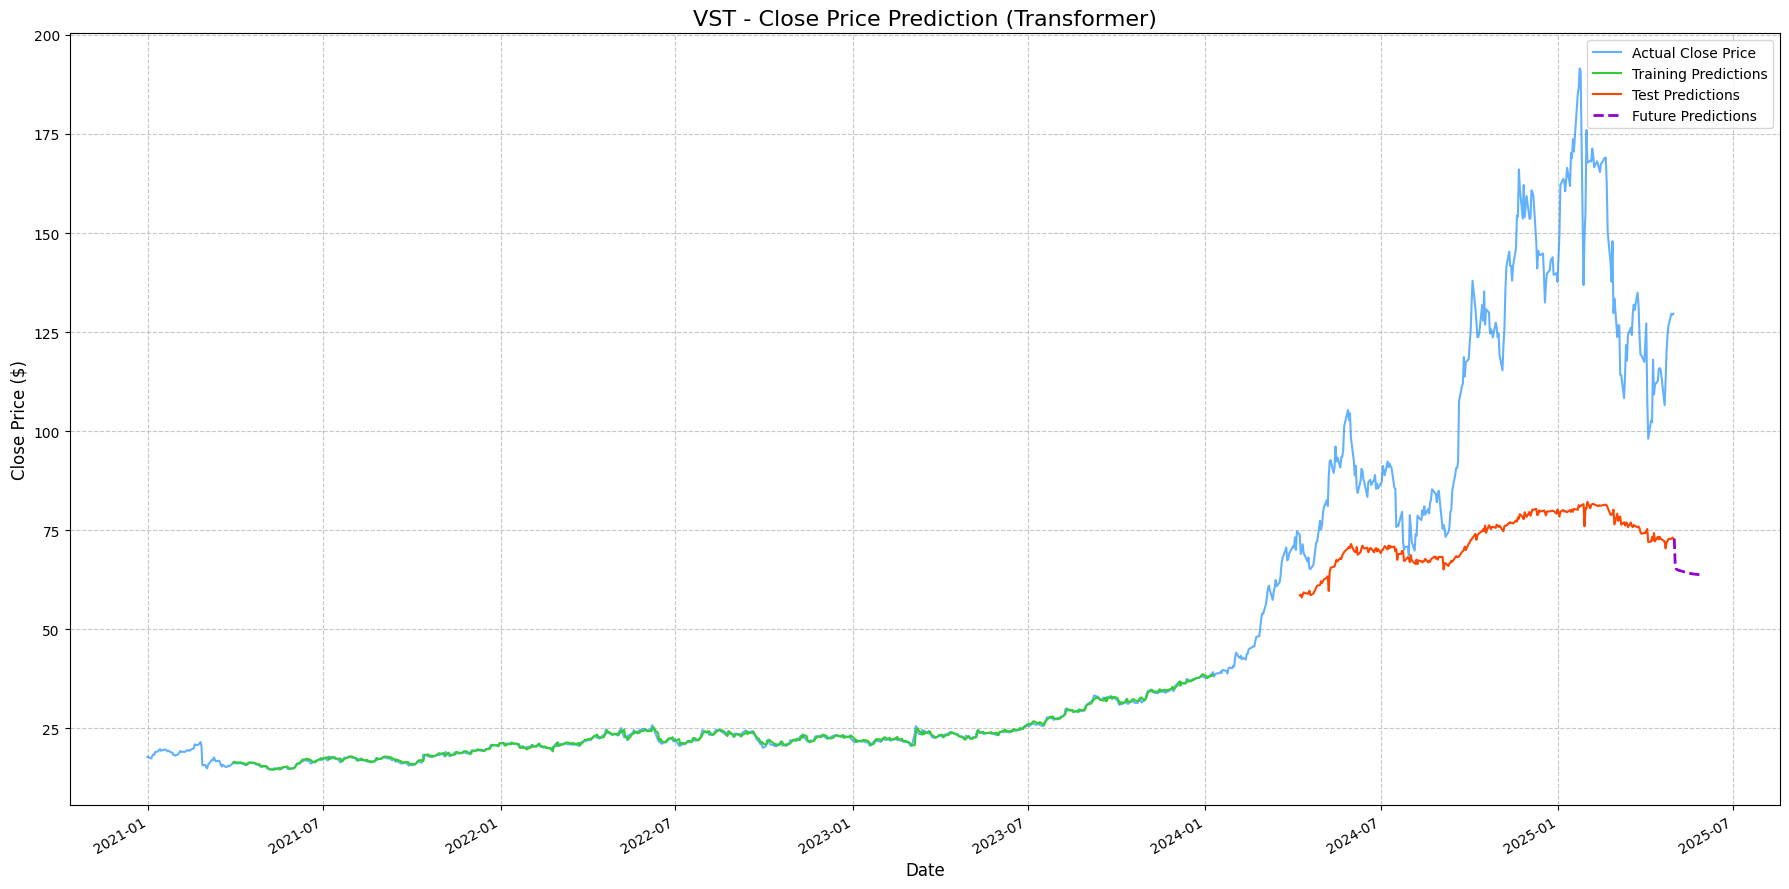

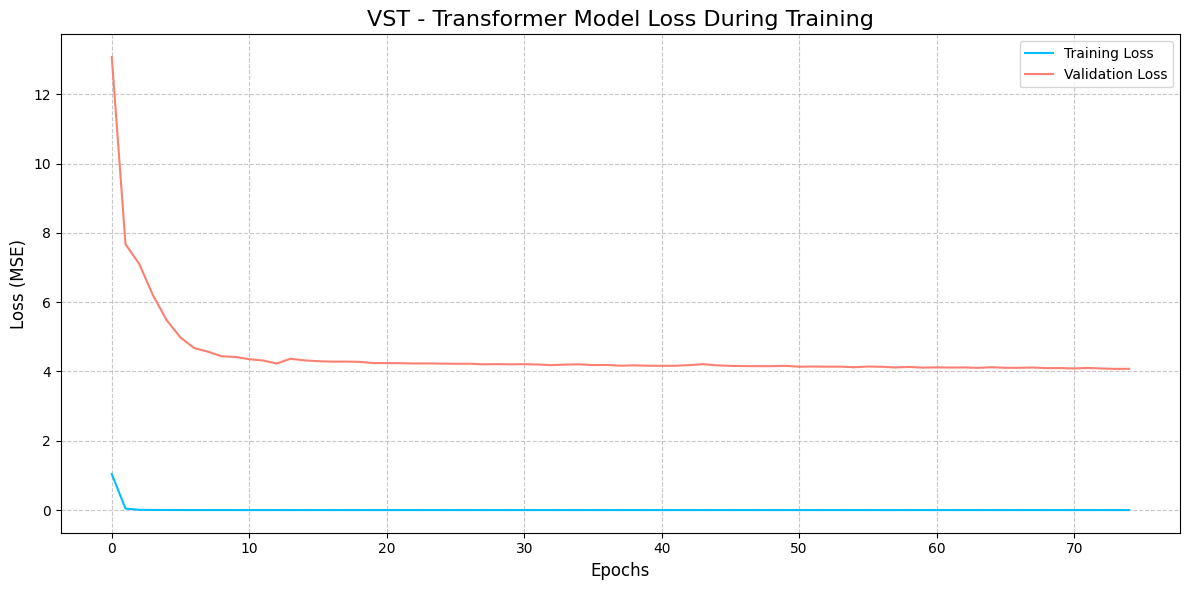

Model saved as 'VST_transformer_model.h5'
Combined historical and future predictions saved to 'VST_transformer_historical_and_future.csv'

Transformer Model Evaluation Metrics:
train_rmse: 0.4500
test_rmse: 49.7408
train_mae: 0.3366
test_mae: 41.7685
train_r2: 0.9931
test_r2: -1.3577

Transformer Future Predictions for the next 30 days:
            Predicted_Close
2025-05-01        72.814606
2025-05-02        66.124367
2025-05-03        65.186356
2025-05-04        64.995399
2025-05-05        64.896385
2025-05-06        64.814049
2025-05-07        64.737885
2025-05-08        64.670158
2025-05-09        64.605751
2025-05-10        64.538994
2025-05-11        64.461090
2025-05-12        64.378166
2025-05-13        64.297226
2025-05-14        64.229706
2025-05-15        64.180504
2025-05-16        64.141708
2025-05-17        64.089951
2025-05-18        64.032669
2025-05-19        63.982056
2025-05-20        63.938534
2025-05-21        63.905254
2025-05-22        63.868069
2025-05-23       

In [176]:
if __name__ == '__main__':
    # Set your desired stock ticker
    GLOBAL_STOCK_TICKER = 'VST' # Make sure this matches your data file

    # Load your processed data
    processed_df = load_your_processed_data(GLOBAL_STOCK_TICKER)

    if processed_df is not None:
        print("\nProcessed data loaded successfully. Running Transformer prediction.")
        # Run the Transformer prediction process
        transformer_model, transformer_metrics, transformer_test_predictions, future_preds, future_dates = predict_transformer(
            processed_df,
            target_col='Close',       # Column to predict
            sequence_length=60,       # Number of past days to use for prediction
            num_transformer_layers=2, # Number of encoder layers
            d_model=64,               # Dimensionality of the model
            num_heads=4,              # Number of attention heads
            dff=128,                  # Dimensionality of the feed-forward network
            dropout_rate=0.1,         # Dropout rate
            epochs=75,                # Maximum training epochs
            batch_size=32,            # Training batch size
            predict_days=30           # Number of future days to predict
        )

        if transformer_metrics:
            print("\nTransformer Model Evaluation Metrics:")
            for metric, value in transformer_metrics.items():
                print(f"{metric}: {value:.4f}")

        if future_preds is not None and future_dates is not None:
            print(f"\nTransformer Future Predictions for the next {len(future_dates)} days:")
            future_df = pd.DataFrame(future_preds.flatten(), index=future_dates, columns=['Predicted_Close'])
            print(future_df)
    else:
        print("\nFailed to load processed data. Transformer prediction cannot proceed.")

